<a href="https://colab.research.google.com/github/bvarel/Liar-NN/blob/main/Machine_Learning_Final_Project_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Project**
## **Background**
Automatic fake news detection is a challenging problem in deception detection, and it has tremendous real-world political and social impacts. However, statistical approaches to combating fake news has been dramatically limited by the lack of labeled benchmark datasets. Here, we use LIAR: a new, publicly available dataset for fake news detection. It is a collection a decade-long, 12.8K manually labeled short statements in various contexts from POLITIFACT.COM, which provides detailed analysis report and links to source documents for each case. We will use this dataset to help train our model to detect Fake News to combat the rapid of false information.

https://arxiv.org/pdf/1705.00648v1.pdf

## Dataset
The LIAR dataset includes 12.8K human labeled short statements from POLITIFACT.COM’s API, and each statement is evaluated by a POLITIFACT.COM editor for its truthfulness. There were six fine-grained labels for the truthfulness ratings: pants-fire, false, barelytrue, half-true, mostly-true, and true. The distribution of labels in the LIAR dataset is relatively well-balanced: except for 1,050 pants-fire cases, the instances for all other labels range from 2,063 to 2,638. 200 instances were randomly sampled in the above paper to examine the accompanied lengthy analysis reports and rulings. The verdict requires extensive training in journalism for finding relevant evidence. Therefore, for second-stage verifications, the individuals went through a randomly sampled subset of the analysis reports and confirmed they agreeded with the reporters’ analysis.

There is also a rich set of meta-data for each speaker—in addition to party affiliations, current job, home state, and credit history are also provided. In particular, the credit history includes the historical counts of inaccurate statements for each speaker. For example, Mitt Romney has a credit history vector h = {19, 32, 34, 58, 33}, which corresponds to his counts of “pants on fire”, “false”, “barely true”, “half true”, “mostly true” for historical statements. Since this vector also includes the count for the current statement, we have subtracted the current label from the credit history when using this meta data vector in prediction experiments These statements are sampled from various of contexts/venues, and the top categories include news releases, TV/radio interviews, campaign speeches, TV ads, tweets, debates, Facebook posts, etc. To ensure a broad coverage o the topics, there is also a diverse set of subjects discussed by the speakers.

In [ ]:
#Only Run these if needed
!pip install datasets

!pip install transformers

     |████████████████████████████████| 312 kB 3.8 MB/s 
     |████████████████████████████████| 67 kB 7.0 MB/s 
     |████████████████████████████████| 1.1 MB 57.1 MB/s 
     |████████████████████████████████| 134 kB 94.1 MB/s 
     |████████████████████████████████| 212 kB 80.6 MB/s 
     |████████████████████████████████| 127 kB 80.1 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 271 kB 93.6 MB/s 
     |████████████████████████████████| 144 kB 99.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.8 MB 4.1 MB/s 


# Load Dataset

In [ ]:
from datasets import load_dataset
import pandas as pd
import nltk
import re
import string
import os
import random
import itertools
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

from transformers import TFAutoModel, AutoTokenizer, BertConfig, TFBertModel
from transformers import DistilBertModel, DistilBertConfig,BertTokenizerFast


dataset = load_dataset("liar")

Downloading:   0%|          | 0.00/2.33k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset liar downloaded and prepared to /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['test'])
validation= pd.DataFrame(dataset['validation'])


train_df = train.fillna('None')
test_df = test.fillna('None')
val_df = validation.fillna('None')

train = train_df.values
test = test_df.values
val = val_df.values

# Preprocessing Dataset

In [ ]:
#Labeling 1 or 0 for true or not true
def label_true (row):
    if row['label'] < 3 :
        return 0
    return 1

train_df['true_false'] = train_df.apply (lambda row: label_true(row), axis=1)
test_df['true_false'] = test_df.apply (lambda row: label_true(row), axis=1)
val_df['true_false'] = val_df.apply (lambda row: label_true(row), axis=1)

In [ ]:

labels = {'train':[train[i][1] for i in range(len(train))], 'test':[test[i][1] for i in range(len(test))], 'val':[val[i][1] for i in range(len(val))]}
statements = {'train':[train[i][2] for i in range(len(train))], 'test':[test[i][2] for i in range(len(test))], 'val':[val[i][2] for i in range(len(val))]}
subjects = {'train':[train[i][3] for i in range(len(train))], 'test':[test[i][3] for i in range(len(test))], 'val':[val[i][3] for i in range(len(val))]}
speakers = {'train':[train[i][4] for i in range(len(train))], 'test':[test[i][4] for i in range(len(test))], 'val':[val[i][4] for i in range(len(val))]}
jobs = {'train':[train[i][5] for i in range(len(train))], 'test':[test[i][5] for i in range(len(test))], 'val':[val[i][5] for i in range(len(val))]}
states = {'train':[train[i][6] for i in range(len(train))], 'test':[test[i][6] for i in range(len(test))], 'val':[val[i][6] for i in range(len(val))]}
affiliations = {'train':[train[i][7] for i in range(len(train))], 'test':[test[i][7] for i in range(len(test))], 'val':[val[i][7] for i in range(len(val))]}
credits = {'train':[train[i][8:13] for i in range(len(train))], 'test':[test[i][8:13] for i in range(len(test))], 'val':[val[i][8:13] for i in range(len(val))]}
contexts= {'train':[train[i][13] for i in range(len(train))], 'test':[test[i][13] for i in range(len(test))], 'val':[val[i][13] for i in range(len(val))]}

In [ ]:
#Combine the metadata so we can use this as an input
metadata = {'train':[0]*len(train), 'val':[0]*len(val), 'test':[0]*len(test)}


for i in range(len(train)):
    subject = subjects['train'][i]
    if subject == 0:
        subject = 'None'
    
    speaker = speakers['train'][i]
    if speaker == 0:
        speaker = 'None'
    
    job = jobs['train'][i]
    if job == 0:
        job = 'None'
    
    state = states['train'][i]
    if state == 0:
        state = 'None'

    affiliation = affiliations['train'][i]
    if affiliation == 0:
        affiliation = 'None'

    context = contexts['train'][i]
    if context== 0 :
        context = 'None'
        
    meta = subject + ' ' + speaker + ' ' + job + ' ' + state + ' ' + affiliation + ' ' + context
    
    #subject_train.append(subject)
    #speaker_train.append(speaker)
    #job_train.append(job)
    #state_train.append(state)
    #affiliation_train.append(affiliation)
    #context_train.append(context)
    
    metadata['train'][i] = meta
    
for i in range(len(val)):
    subject = subjects['val'][i]
    if subject == 0:
        subject = 'None'
    
    speaker = speakers['val'][i]
    if speaker == 0:
        speaker = 'None'
    
    job = jobs['val'][i]
    if job == 0:
        job = 'None'
    
    state = states['val'][i]
    if state == 0:
        state = 'None'

    affiliation = affiliations['val'][i]
    if affiliation == 0:
        affiliation = 'None'

    context = contexts['val'][i]
    if context == 0 :
        context = 'None'
        
    meta = subject + ' ' + speaker + ' ' + job + ' ' + state + ' ' + affiliation + ' ' + context
    
    metadata['val'][i] = meta
    
for i in range(len(test)):
    subject = subjects['test'][i]
    if subject == 0:
        subject = 'None'
    
    speaker = speakers['test'][i]
    if speaker == 0:
        speaker = 'None'
    
    job = jobs['test'][i]
    if job == 0:
        job = 'None'
    
    state = states['test'][i]
    if state == 0:
        state = 'None'

    affiliation = affiliations['test'][i]
    if affiliation == 0:
        affiliation = 'None'

    context = contexts['test'][i]
    if context == 0 :
        context = 'None'
        
    meta = subject + ' ' + speaker + ' ' + job + ' ' + state + ' ' + affiliation + ' ' + context
    
    metadata['test'][i] = meta

In [ ]:
train_df['metadata']= metadata['train']
test_df['metadata']= metadata['test']
val_df['metadata']= metadata['val']

In [ ]:
X_train_statement = train_df['statement']
X_test_statement = test_df['statement']
X_val_statement = val_df['statement']

y_train = train_df['true_false']
y_val = val_df['true_false']
y_test = test_df['true_false']

print(X_train_statement.shape, X_test_statement.shape, X_val_statement.shape)
print(y_train.shape, y_test.shape,y_val.shape)

(10269,) (1283,) (1284,)
(10269,) (1283,) (1284,)


In [ ]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    
#converting our inputs into what needs to be fed into the model
def convert_to_transformer_inputs(str1, str2, tokenizer, max_sequence_length, double=True):
    
    def return_id(str1, str2, truncation_strategy, length):

        inputs = tokenizer.encode_plus(str1, str2,
            add_special_tokens=True,
            max_length=length,
            truncation_strategy=truncation_strategy)
        
        input_ids =  inputs["input_ids"]
        input_masks = [1] * len(input_ids)
        input_segments = inputs["token_type_ids"]
        
        padding_length = length - len(input_ids)
        padding_id = tokenizer.pad_token_id
        
        input_ids = input_ids + ([padding_id] * padding_length)
        input_masks = input_masks + ([0] * padding_length)
        input_segments = input_segments + ([0] * padding_length)
        
        return [input_ids, input_masks, input_segments]
    
    if double:
    
        input_ids_1, input_masks_1, input_segments_1 = return_id(
            str1, None, 'longest_first', max_sequence_length)

        input_ids_2, input_masks_2, input_segments_2 = return_id(
            str2, None, 'longest_first', max_sequence_length)

        return [input_ids_1, input_masks_1, input_segments_1,
                input_ids_2, input_masks_2, input_segments_2]
    
    else:
        
        input_ids, input_masks, input_segments = return_id(
            str1, str2, 'longest_first', max_sequence_length)

        return [input_ids, input_masks, input_segments,
                None, None, None]        

#setting up our inputs using the tokenizer
def compute_input_arrays(df, columns, tokenizer, max_sequence_length, double=True):
    
    input_ids_1, input_masks_1, input_segments_1 = [], [], []
    input_ids_2, input_masks_2, input_segments_2 = [], [], []
    for _, instance in tqdm(df[columns].iterrows(), total=len(df)):
        str1, str2 = instance[columns[0]], instance[columns[1]]

        ids_1, masks_1, segments_1, ids_2, masks_2, segments_2 = \
        convert_to_transformer_inputs(str1, str2, tokenizer, max_sequence_length, double=double)
        
        input_ids_1.append(ids_1)
        input_masks_1.append(masks_1)
        input_segments_1.append(segments_1)

        input_ids_2.append(ids_2)
        input_masks_2.append(masks_2)
        input_segments_2.append(segments_2)
        
    if double:
        
        return [np.asarray(input_ids_1, dtype=np.int32), 
                np.asarray(input_masks_1, dtype=np.int32), 
                np.asarray(input_segments_1, dtype=np.int32),
                np.asarray(input_ids_2, dtype=np.int32), 
                np.asarray(input_masks_2, dtype=np.int32), 
                np.asarray(input_segments_2, dtype=np.int32)]
    
    else:
        
        return [np.asarray(input_ids_1, dtype=np.int32), 
                np.asarray(input_masks_1, dtype=np.int32), 
                np.asarray(input_segments_1, dtype=np.int32)]
#Confusion Matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)


In [ ]:
MAX_SEQUENCE_LENGTH = 300
#maybe try 128?

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", padding=True, truncation=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
input_train = compute_input_arrays(train_df, ['statement','metadata'], tokenizer, MAX_SEQUENCE_LENGTH, double=False)
input_val = compute_input_arrays(val_df, ['statement','metadata'], tokenizer, MAX_SEQUENCE_LENGTH, double=False)
input_test = compute_input_arrays(test_df, ['statement','metadata'], tokenizer, MAX_SEQUENCE_LENGTH, double=False)

  0%|          | 0/10269 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/1284 [00:00<?, ?it/s]

  0%|          | 0/1283 [00:00<?, ?it/s]

In [ ]:
map_label = dict(enumerate(train_df.true_false.factorize()[1]))
map_label

{0: 0, 1: 1}

## **SIMPLE BERT (ONE INPUT)**

https://towardsdatascience.com/siamese-and-dual-bert-for-multi-text-classification-c6552d435533

In [ ]:
def simple_bert():
    
    set_seed(33)
    
    opt = Adam(learning_rate=2e-5)
    
    id_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    mask_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    atn_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    config = BertConfig()
    config.output_hidden_states = False # Set to True to obtain hidden states
    bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)
    
    embedding = bert_model(id_, attention_mask=mask_, token_type_ids=atn_)[0]
    
    x = GlobalAveragePooling1D()(embedding)    
    x = Dropout(0.2)(x)
    out = Dense(len(map_label), activation='softmax')(x)

    model = Model(inputs=[id_, mask_, atn_], outputs=out)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
    
    return model

In [ ]:
model = simple_bert()
model.fit(input_train, y_train,validation_data = [input_val,y_val], epochs=3, batch_size=16)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
642/642 [==============================] - 756s 1s/step - loss: 0.7025 - accuracy: 0.5588 - val_loss: 0.6770 - val_accuracy: 0.5981
Epoch 2/3
642/642 [==============================] - 746s 1s/step - loss: 0.6474 - accuracy: 0.6243 - val_loss: 0.6988 - val_accuracy: 0.5826
Epoch 3/3
642/642 [==============================] - 747s 1s/step - loss: 0.4883 - accuracy: 0.7601 - val_loss: 0.8510 - val_accuracy: 0.5896


In [ ]:
### PREDICT TEST ###

pred_test = np.argmax(model.predict(input_test), axis=1)

print(classification_report([map_label[i] for i in y_test], [map_label[i] for i in pred_test]))

              precision    recall  f1-score   support

           0       0.61      0.84      0.71       766
           1       0.47      0.22      0.30       517

    accuracy                           0.59      1283
   macro avg       0.54      0.53      0.50      1283
weighted avg       0.56      0.59      0.54      1283



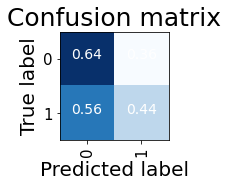

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]',            